In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Text Processing and NLP
import emoji
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Machine Learning
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download("vader_lexicon")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.6 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Feature Extraction - Without Stopwords

In [ ]:

df = pd.read_csv("00_dataset/with_stopwords/cleaned_reviews_sw.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,user_id,prod_id,review_text,rating,label,cleaned_text_sw
0,5044,0,"Drinks were bad, the hot chocolate was watered...",1.0,1,"Drinks be bad , the hot chocolate be water dow..."
1,5045,0,This was the worst experience I've ever had a ...,1.0,1,This be the bad experience I have ever have a ...
2,5046,0,This is located on the site of the old Spruce ...,3.0,1,This be locate on the site of the old Spruce S...
3,5047,0,I enjoyed coffee and breakfast twice at Toast ...,5.0,1,I enjoy coffee and breakfast twice at Toast du...
4,5048,0,I love Toast! The food choices are fantastic -...,5.0,1,I love Toast ! The food choice be fantastic - ...


In [ ]:
print(df.isnull().sum())


user_id            0
prod_id            0
review_text        0
rating             0
label              0
cleaned_text_sw    0
dtype: int64


In [ ]:
df["cleaned_text_sw"] = df["cleaned_text_sw"].fillna("")

In [ ]:
X = df["cleaned_text_sw"]
y = df["label"]

# First, split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Next, split Train (80%) into Train (70%) and Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=42)

print("Training set: ", len(X_train))
print("Test set: ", len(X_test))
print("Validation set: ", len(X_val))

Training set:  425920
Test set:  121692
Validation set:  60846


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)  # Top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
import numpy as np
import joblib
import os
from sklearn.decomposition import IncrementalPCA

# Define settings
batch_size = 1000  # Adjust based on memory availability
# checkpoint_file = "00_dataset/without_stopwords/pca/incremental_pca_checkpoint.joblib"  # Checkpoint filename
checkpoint_file = "/content/drive/My Drive/Johnathan/pca/incremental_pca_checkpoint.joblib"  # Checkpoint filename

# Check if checkpoint exists to resume training
if os.path.exists(checkpoint_file):
    print("🔄 Resuming from last saved checkpoint...")
    ipca = joblib.load(checkpoint_file)
else:
    print("🚀 Starting new Incremental PCA...")
    ipca = IncrementalPCA()

# Fit PCA in batches and save model after each batch
for i in range(0, X_train_tfidf.shape[0], batch_size):
    batch = X_train_tfidf[i:i+batch_size].toarray()  # Convert only batch to dense if necessary
    ipca.partial_fit(batch)  # Update Incremental PCA model

    # Save model checkpoint after each batch
    joblib.dump(ipca, checkpoint_file)
    print(f"✅ Saved checkpoint after processing batch {i // batch_size + 1}")

print("🎉 Incremental PCA completed successfully!")

# Step 2: Compute Cumulative Explained Variance to Find Optimal n_components
cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)

🚀 Starting new Incremental PCA...
✅ Saved checkpoint after processing batch 1
✅ Saved checkpoint after processing batch 2
✅ Saved checkpoint after processing batch 3
✅ Saved checkpoint after processing batch 4
✅ Saved checkpoint after processing batch 5
✅ Saved checkpoint after processing batch 6
✅ Saved checkpoint after processing batch 7
✅ Saved checkpoint after processing batch 8
✅ Saved checkpoint after processing batch 9
✅ Saved checkpoint after processing batch 10
✅ Saved checkpoint after processing batch 11
✅ Saved checkpoint after processing batch 12
✅ Saved checkpoint after processing batch 13
✅ Saved checkpoint after processing batch 14
✅ Saved checkpoint after processing batch 15
✅ Saved checkpoint after processing batch 16
✅ Saved checkpoint after processing batch 17
✅ Saved checkpoint after processing batch 18
✅ Saved checkpoint after processing batch 19
✅ Saved checkpoint after processing batch 20
✅ Saved checkpoint after processing batch 21
✅ Saved checkpoint after proce

KeyboardInterrupt: 

In [ ]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Determine optimal number of components for 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {optimal_n_components}")

# Save the final model
final_model_file = "final_pca_model.joblib"
joblib.dump(ipca, final_model_file)
print("✅ Final Incremental PCA model saved successfully!")

Garbage collection counts before: (603, 5, 34)
Garbage collection counts after: (80, 0, 0)


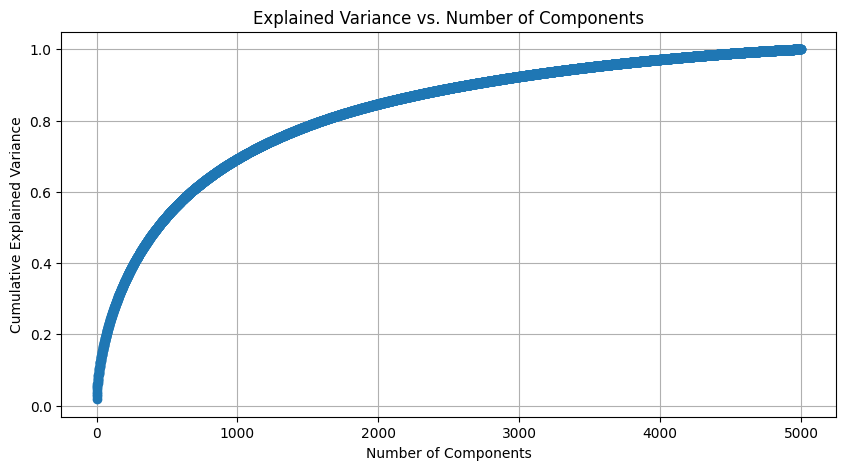

✅ Number of components explaining 95% variance: 3500
Optimal Number of Components: 3500
✅ Final Truncated SVD model saved successfully!


In [ ]:
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Convert X_train_tfidf to a sparse matrix for efficiency
X_train_tfidf_sparse = csr_matrix(X_train_tfidf)


# Define maximum components (adjust based on dataset)
max_components = min(5000, X_train_tfidf.shape[1])  # Limit to 1000 or feature count

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=max_components, random_state=42)


# Fit and transform data
X_train_svd = svd.fit_transform(X_train_tfidf_sparse)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Find the number of components that explain 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"✅ Number of components explaining 95% variance: {optimal_n_components}")

threshold = 0.95
if np.any(cumulative_variance >= threshold):
    optimal_n_components = np.argmax(cumulative_variance >= threshold) + 1
else:
    optimal_n_components = len(cumulative_variance)  # Take max available components
    print(f"⚠️ Warning: 95% variance not reached. Using {optimal_n_components} components instead.")

print(f"Optimal Number of Components: {optimal_n_components}")

# 🔹 Step 5: Retrain SVD with the Optimal Number of Components
svd = TruncatedSVD(n_components=optimal_n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf_sparse)

# 🔹 Step 6: Save Final SVD Model
joblib.dump(svd, "final_svd_model.joblib")
print("✅ Final Truncated SVD model saved successfully!")

Preprocessing 2 with sampling and pca

In [ ]:
vectorizer = TfidfVectorizer(max_features=4000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
print("TF-IDF vectorizer saved.")

TF-IDF vectorizer saved.


In [ ]:
# optimal_n_components = 3624
optimal_n_components = 3500
# Initialize Truncated SVD
svd = TruncatedSVD(n_components=optimal_n_components, random_state=42)

# Convert TF-IDF to a sparse matrix (if not already sparse)
X_train_tfidf_sparse = csr_matrix(X_train_tfidf)
X_val_tfidf_sparse   = csr_matrix(X_val_tfidf)
X_test_tfidf_sparse  = csr_matrix(X_test_tfidf)

X_train_svd = svd.fit_transform(X_train_tfidf_sparse)
X_test_svd = svd.transform(X_test_tfidf)
X_val_svd = svd.transform(X_val_tfidf)

joblib.dump(svd, "final_svd_model.joblib")
print("Final Truncated SVD model saved.")

Final Truncated SVD model saved.


In [ ]:
# Load your pre-saved final SVD model.
svd = joblib.load("final_svd_model.joblib")

# Check the number of components used
print("Optimal number of components:", svd.n_components)

# Compute the cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
print("Total variance explained:", cumulative_variance[-1])

Optimal number of components: 3500
Total variance explained: 0.9813755352050189


In [ ]:
from scipy.sparse import csr_matrix

# Convert TF-IDF to a sparse matrix (if not already sparse)
X_train_tfidf_sparse = csr_matrix(X_train_tfidf)
X_val_tfidf_sparse   = csr_matrix(X_val_tfidf)
X_test_tfidf_sparse  = csr_matrix(X_test_tfidf)

X_train_svd = svd.transform(X_train_tfidf_sparse)
X_val_svd   = svd.transform(X_val_tfidf_sparse)
X_test_svd  = svd.transform(X_test_tfidf_sparse)

print("SVD transformation complete.")

SVD transformation complete.


In [ ]:
sia = SentimentIntensityAnalyzer()

def extract_features(text):
    sentiment_score = TextBlob(text).sentiment.polarity  # Sentiment (-1 to +1)
    vader_score = sia.polarity_scores(text)["compound"]  # VADER sentiment
    review_length = len(text.split())  # Word count
    exclamation_count = text.count("!")  # Number of !
    question_count = text.count("?")  # Number of ?
    uppercase_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0  # % uppercase
    duplicate_word_count = len([w for w in text.split() if text.split().count(w) > 1])  # Repeated words
    emoji_count = len([char for char in text if char in emoji.EMOJI_DATA])  # Count emojis
    avg_word_length = sum(len(word) for word in text.split()) / review_length if review_length > 0 else 0  # Avg word length

    return [sentiment_score, vader_score, review_length, exclamation_count, question_count, uppercase_ratio,
            duplicate_word_count, emoji_count, avg_word_length]

# Apply feature extraction to dataset
df_train_features = X_train.apply(extract_features)
df_test_features = X_test.apply(extract_features)
df_val_features = X_val.apply(extract_features)

features_cols = ["sentiment_score", "vader_score", "review_length",
                 "exclamation_count", "question_count", "uppercase_ratio",
                 "duplicate_word_count", "emoji_count", "avg_word_length"]

df_train_features = pd.DataFrame(df_train_features.tolist(), columns=features_cols)
df_test_features = pd.DataFrame(df_test_features.tolist(), columns=features_cols)
df_val_features = pd.DataFrame(df_val_features.tolist(), columns=features_cols)
print("Engineered features extracted.")

Engineered features extracted.


In [ ]:
# Convert TF-IDF dense matrix to DataFrame
df_train_svd = pd.DataFrame(X_train_svd)
df_test_svd = pd.DataFrame(X_test_svd)
df_val_svd = pd.DataFrame(X_val_svd)

# **Check if row counts match before merging**
assert df_train_svd.shape[0] == df_train_features.shape[0], "Mismatch in train set sizes!"
assert df_test_svd.shape[0] == df_test_features.shape[0], "Mismatch in test set sizes!"
assert df_val_svd.shape[0] == df_val_features.shape[0], "Mismatch in validation set sizes!"

In [ ]:
# Reset indices for training set
df_train_svd.reset_index(drop=True, inplace=True)
df_train_features.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Reset indices for testing set
df_test_svd.reset_index(drop=True, inplace=True)
df_test_features.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Reset indices for validation set
df_val_svd.reset_index(drop=True, inplace=True)
df_val_features.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


df_y_train = pd.DataFrame(y_train, columns=["label"])
df_y_test = pd.DataFrame(y_test, columns=["label"])
df_y_val = pd.DataFrame(y_val, columns=["label"])

# Check if the row counts of y labels match the features before merging
assert df_train_svd.shape[0] == df_y_train.shape[0], "Mismatch in train labels!"
assert df_test_svd.shape[0] == df_y_test.shape[0], "Mismatch in test labels!"
assert df_val_svd.shape[0] == df_y_val.shape[0], "Mismatch in validation labels!"

# Check if indices match
print(df_train_svd.index.equals(df_y_train.index))  # Should be True
print(df_test_svd.index.equals(df_test_features.index))    # Should be True
print(df_val_svd.index.equals(df_y_val.index))      # Should be True

# Check if indices match
print(df_train_svd.index.equals(df_train_features.index))  # Should be True
print(df_test_svd.index.equals(df_y_test.index))    # Should be True
print(df_val_svd.index.equals(df_val_features.index))      # Should be True

True
True
True
True
True
True


In [ ]:
# Merge TF-IDF with extracted features
df_train_combined = pd.concat([df_train_svd, df_train_features, df_y_train], axis=1)
df_test_combined = pd.concat([df_test_svd, df_test_features, df_y_test], axis=1)
df_val_combined = pd.concat([df_val_svd, df_val_features, df_y_val], axis=1)

print("NaN values in train set:\n", df_train_combined.isna().sum())
print("NaN values in test set:\n", df_test_combined.isna().sum())
print("NaN values in validation set:\n", df_val_combined.isna().sum())

NaN values in train set:
 0                       0
1                       0
2                       0
3                       0
4                       0
                       ..
uppercase_ratio         0
duplicate_word_count    0
emoji_count             0
avg_word_length         0
label                   0
Length: 3510, dtype: int64
NaN values in test set:
 0                       0
1                       0
2                       0
3                       0
4                       0
                       ..
uppercase_ratio         0
duplicate_word_count    0
emoji_count             0
avg_word_length         0
label                   0
Length: 3510, dtype: int64
NaN values in validation set:
 0                       0
1                       0
2                       0
3                       0
4                       0
                       ..
uppercase_ratio         0
duplicate_word_count    0
emoji_count             0
avg_word_length         0
label                   0
Length

In [ ]:
df_train_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.424830,-0.022449,0.017032,0.081257,-0.065847,0.051942,0.034020,-0.007094,-0.011639,-0.043487,...,0.211111,0.9548,126,0,0,0.018395,59,0,3.753968,0
1,0.424149,0.034423,-0.052805,-0.073026,-0.024477,0.080064,0.033736,0.092192,-0.056684,-0.096770,...,0.152564,0.9647,83,1,0,0.020151,35,0,3.795181,0
2,0.368134,-0.046799,-0.018160,0.085754,-0.062730,0.060534,0.028130,-0.032785,-0.004970,-0.013849,...,-0.147253,0.7906,66,0,0,0.020761,29,0,3.393939,0
3,0.475376,0.058243,-0.049584,-0.039273,0.002970,-0.105714,-0.074218,0.052472,-0.057391,-0.008375,...,0.320036,0.9910,166,8,0,0.054917,86,0,3.722892,0
4,0.367318,0.044135,0.028983,0.123555,-0.053754,0.008549,0.023938,0.019133,-0.076440,-0.086310,...,0.300000,0.8832,83,0,0,0.029777,41,0,3.867470,0


In [ ]:
df_test_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.120022,0.146673,-0.067211,-0.101282,0.042351,-0.068490,-0.002712,0.040061,-0.034780,-0.077507,...,0.725000,0.9693,26,3,0,0.111111,3,0,3.884615,0
1,0.158455,0.002168,-0.037426,-0.054167,-0.013032,0.060210,0.036985,0.021410,0.016812,0.046302,...,0.068333,0.1484,54,0,0,0.056680,21,0,3.592593,0
2,0.275822,-0.006218,0.015035,0.117496,0.010598,-0.093369,-0.015504,0.161277,0.076885,0.039988,...,0.201161,0.9198,51,3,0,0.026201,21,0,3.509804,1
3,0.431000,-0.114847,-0.140019,-0.079769,-0.058966,0.066713,-0.015839,0.011356,-0.027287,0.052588,...,0.212113,0.9751,138,2,0,0.026846,78,0,3.326087,0
4,0.300413,0.074478,0.007124,0.064774,-0.038825,-0.068343,0.037944,-0.059964,-0.044505,-0.007409,...,0.583333,0.9859,88,3,0,0.048276,29,0,3.954545,0


In [ ]:
df_val_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.501131,0.037140,0.041660,0.136154,-0.061591,-0.048022,-0.071296,-0.012405,-0.034556,-0.052778,...,0.065255,0.9925,252,2,0,0.026408,146,0,3.511905,0
1,0.192535,0.119688,-0.096254,-0.140735,0.017765,0.007459,0.041459,0.034202,-0.011152,-0.049537,...,0.150000,0.6360,29,1,0,0.033333,5,0,3.172414,0
2,0.346130,0.033406,0.101449,-0.024034,0.012493,0.101972,-0.023581,-0.006258,0.004803,0.092592,...,0.200000,0.9432,62,0,0,0.020478,34,0,3.741935,0
3,0.482258,0.004154,-0.043264,0.115061,-0.094376,-0.108305,-0.178661,-0.161975,-0.141891,0.047164,...,0.221902,0.9968,311,1,0,0.012221,214,0,3.475884,0
4,0.431728,0.011393,0.102411,-0.048447,0.012727,0.092149,0.022228,0.031639,0.056216,-0.004714,...,-0.123810,-0.3400,67,0,0,0.019868,29,0,3.522388,1


In [ ]:
df_train_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Columns: 3510 entries, 0 to label
dtypes: float64(3504), int64(6)
memory usage: 11.1 GB


In [ ]:
# Convert all float64 columns to float32
float_cols = df_train_combined.select_dtypes(include=['float64']).columns
df_train_combined[float_cols] = df_train_combined[float_cols].astype(np.float32)

# Convert all int64 columns to int16 if they fit the range (-32768 to 32767), otherwise use int32
int_cols = df_train_combined.select_dtypes(include=['int64']).columns
for col in int_cols:
    col_min = df_train_combined[col].min()
    col_max = df_train_combined[col].max()
    if col_min >= -32768 and col_max <= 32767:
        df_train_combined[col] = df_train_combined[col].astype(np.int16)
    else:
        df_train_combined[col] = df_train_combined[col].astype(np.int32)

# Verify the changes
print(df_train_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Columns: 3510 entries, 0 to label
dtypes: float32(3504), int16(6)
memory usage: 5.6 GB
None


In [ ]:
df_test_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121692 entries, 0 to 121691
Columns: 3510 entries, 0 to label
dtypes: float64(3504), int64(6)
memory usage: 3.2 GB


In [ ]:
# Convert all float64 columns to float32
float_cols_test = df_test_combined.select_dtypes(include=['float64']).columns
df_test_combined[float_cols_test] = df_test_combined[float_cols_test].astype(np.float32)

# Convert all int64 columns to int16 if they fit the range (-32768 to 32767), otherwise use int32
int_cols = df_test_combined.select_dtypes(include=['int64']).columns
for col in int_cols:
    col_min = df_test_combined[col].min()
    col_max = df_test_combined[col].max()
    if col_min >= -32768 and col_max <= 32767:
        df_test_combined[col] = df_test_combined[col].astype(np.int16)
    else:
        df_test_combined[col] = df_test_combined[col].astype(np.int32)

# Verify the changes
print(df_test_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121692 entries, 0 to 121691
Columns: 3510 entries, 0 to label
dtypes: float32(3504), int16(6)
memory usage: 1.6 GB
None


In [ ]:
df_val_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60846 entries, 0 to 60845
Columns: 3510 entries, 0 to label
dtypes: float64(3504), int64(6)
memory usage: 1.6 GB


In [ ]:
# Convert all float64 columns to float32
float_cols_val = df_val_combined.select_dtypes(include=['float64']).columns
df_val_combined[float_cols_val] = df_val_combined[float_cols_val].astype(np.float32)

# Convert all int64 columns to int16 if they fit the range (-32768 to 32767), otherwise use int32
int_cols = df_val_combined.select_dtypes(include=['int64']).columns
for col in int_cols:
    col_min = df_val_combined[col].min()
    col_max = df_val_combined[col].max()
    if col_min >= -32768 and col_max <= 32767:
        df_val_combined[col] = df_val_combined[col].astype(np.int16)
    else:
        df_val_combined[col] = df_val_combined[col].astype(np.int32)

# Verify the changes
print(df_val_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60846 entries, 0 to 60845
Columns: 3510 entries, 0 to label
dtypes: float32(3504), int16(6)
memory usage: 814.0 MB
None


In [ ]:
import pyarrow.parquet

df_train_combined.to_parquet("00_dataset/with_stopwords/train_features_sw_svd.parquet", index=False)
df_test_combined.to_parquet("00_dataset/with_stopwords/test_features_sw_svd.parquet", index=False)
df_val_combined.to_parquet("00_dataset/with_stopwords/val_features_sw_svd.parquet", index=False)
print("Features saved successfully")

Features saved successfully


In [ ]:
# Initialize SMOTE (you can adjust sampling_strategy and random_state as needed)
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the SVD-transformed training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_svd, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

Garbage collection counts before: (437, 2, 0)
Garbage collection counts after: (28, 0, 0)
Before SMOTE: [369613  56307]
After SMOTE: [369613 369613]


In [ ]:
# Save the resampled data to a file using joblib
joblib.dump((X_train_resampled, y_train_resampled), "resampled_training_data.joblib")
print("Resampled training data saved successfully!")

Resampled training data saved successfully!


In [ ]:
# Load the resampled training data
X_train_resampled, y_train_resampled = joblib.load("resampled_training_data.joblib")
print("Resampled training data loaded.")

In [ ]:
import joblib
import pandas as pd
import numpy as np

# Load test data
train_df = pd.read_parquet("00_dataset/with_stopwords/train_features_sw_svd.parquet")

# Load test data
test_df = pd.read_parquet("00_dataset/with_stopwords/test_features_sw_svd.parquet")

# Load val data
val_df = pd.read_parquet("00_dataset/with_stopwords/val_features_sw_svd.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Separate into X and y
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

X_val = val_df.drop(columns=["label"])
y_val = val_df["label"]

15

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
rf_model = RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced')

rf_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
bal_test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Test Accuracy: {bal_test_accuracy:.2f}")

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Test Accuracy: 0.87
Balanced Test Accuracy: 0.51

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93    105604
           1       0.50      0.02      0.03     16088

    accuracy                           0.87    121692
   macro avg       0.68      0.51      0.48    121692
weighted avg       0.82      0.87      0.81    121692



Random Forest -> MinMaxScaler + SMOTE + SVD

Validation Set
Validation Accuracy: 0.859284094270782
Balanced Validation Accuracy: 0.5234414528660226
ROC-AUC Score: 0.663132251848574

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92     52802
           1       0.34      0.07      0.11      8044

    accuracy                           0.86     60846
   macro avg       0.61      0.52      0.52     60846
weighted avg       0.80      0.86      0.82     60846



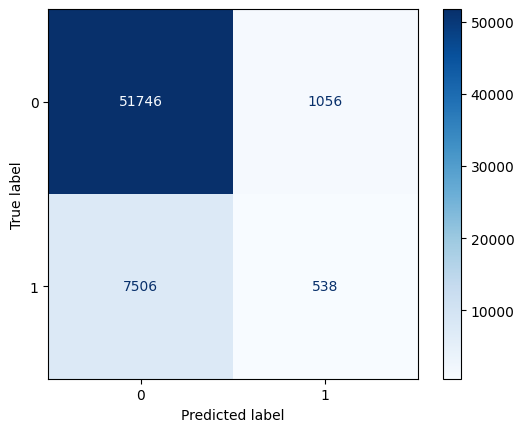

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score,roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Feature Scaling
ct = ColumnTransformer(transformers=[('MinMaxScaler', MinMaxScaler(), ['sentiment_score', 'vader_score', 'review_length', 'exclamation_count', 'question_count', 'uppercase_ratio', 'duplicate_word_count', 'emoji_count', 'avg_word_length'])], remainder='passthrough')
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)
X_val_scaled = ct.transform(X_val)

smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
joblib.dump((X_train_resampled, y_train_resampled), 'svd_smote.joblib')

rf_model = RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced')

rf_model.fit(X_train_resampled, y_train_resampled)

joblib.dump(rf_model, 'svd_rf_model.joblib')

# Predict on the validation set
y_val_pred = rf_model.predict(X_val_scaled)
print("Validation Set")
# Compute validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
bal_val_accuracy = balanced_accuracy_score(y_val, y_val_pred)
print(f"Balanced Validation Accuracy: {bal_val_accuracy}")
y_val_pred_proba = rf_model.predict_proba(X_val_scaled)[:, 1]
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_pred_proba)}")

# Print Classification Report
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")


Test Set

Test Set
Test Accuracy: 0.8602701903165368
Balanced Test Accuracy: 0.527170940683029
ROC-AUC Score: 0.6653258457220939

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92    105604
           1       0.36      0.07      0.12     16088

    accuracy                           0.86    121692
   macro avg       0.62      0.53      0.52    121692
weighted avg       0.81      0.86      0.82    121692



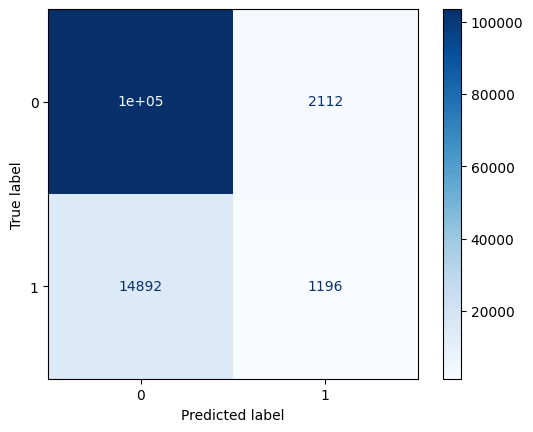

In [ ]:
# Predict on the test set
y_test_pred = rf_model.predict(X_test_scaled)
print("Test Set")
# Compute validation accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
bal_test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Test Accuracy: {bal_test_accuracy}")
y_test_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_pred_proba)}")

# Print Classification Report
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")